# Magnetic and Diagenetic Analyses of Brachfeld et al. (2001)
_____

Paper doi: https://doi.org/10.2973/odp.proc.sr.178.233.2001
Extra TOC data: http://www-odp.tamu.edu/publications/178_SR/chap_15/chap_15.htm
We use the age data given in the ODP proceedings so that we don't have to deal with mbsf-mcd conversions

Core: ODP Leg 178, Site 1096, 67°34.0086´S, 76°57.7936´W.

Water depth: 3152 m

Data in analysis: Magnetite wt. % (from Ms measurements), sedimentation rate, total organic carbon, pore water chemistry.


In [6]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # for legend creation
import numpy as np
import data_fns
%matplotlib inline
plt.rcParams["pdf.fonttype"] = "3"
plt.rcParams["font.family"] = "Avenir"

In [7]:
# read in data
Ms = pd.read_excel("data/brachfeld2001.xlsx", sheet_name="Ms")
# TOC and geochem data from holes A/B/C are all combined
# the supplement has some extra TOC and also sedimentation rates
TOC = pd.read_excel("data/brachfeld2001.xlsx", sheet_name="comb_TOC")
geochem = pd.read_excel("data/brachfeld2001.xlsx", sheet_name="comb_geochem")
other_TOC = pd.read_excel("data/brachfeld2001.xlsx", sheet_name="other-TOC")
ages = pd.read_excel("data/brachfeld2001.xlsx", sheet_name="ages")

# unit conversions
# converting from mass fraction to ppm requires factor of 10^6
Ms["Magnetite [ppm]"] = Ms["Ms [mA m**2/kg]"] * (10**6 / (1000 * 92))
Ms["Magnetite [wt. %]"] = Ms["Ms [mA m**2/kg]"] * (10**2 / (1000 * 92))

# calculate sed rates
sed_rates = data_fns.sed_rates(ages["Age (Ma)"], ages["Depth (mbsf)"])

This data set is especially *fun*, because we have to convert from sample label to a depth. When I first wrote the conversion, it ran as something like O(n^2), but now I think it's more like O(n) (constant time for each sample). The general strategy: Ms points are given with sample labels. We use the shipboard coring summaries for conversion. The summaries tell us the mbsf depth of the top of each section (specified in sample label). So look up the appropriate core (e.g. 4H) and the appropriate section (e.g. 3). Then add the center of the interval (which is given in cm) to the depth we just looked up.

In [8]:
# convert the sample labels to depths (see data_fns.py for code details)
A_summary = data_fns.read_summaries("data/brachfeld2001.xlsx", "A summary")
B_summary = data_fns.read_summaries("data/brachfeld2001.xlsx", "B summary")
C_summary = data_fns.read_summaries("data/brachfeld2001.xlsx", "C summary")

sample_depths = data_fns.depth_convert(Ms["Sample label"], A_summary, B_summary, C_summary)


In [9]:
# build the DFs
Ms_df = pd.DataFrame({"Depth [mbsf]":sample_depths, "Magnetite [ppm]":Ms["Magnetite [ppm]"], "Magnetite [wt. %]":Ms["Magnetite [wt. %]"]})
geochem_df = pd.DataFrame({"Depth [mbsf]":geochem["Depth (mbsf)"], "Sulfate [mM]" : geochem["Sulfate(SO4) (mM)"]})
TOC_df = pd.DataFrame({"Depth [mbsf]":TOC["Depth (mbsf)"], "TOC [wt. %]":TOC["ORG_C (wt %)"]})
other_TOC_df = pd.DataFrame({"Depth [mbsf]":other_TOC["Depth [m]"], "TOC [wt. %]":other_TOC["TOC [%]"]})
sed_rates_df = pd.DataFrame({"Depth [mbsf]":ages["Depth (mbsf)"], "Sedimentation Rate [m/Myr]":sed_rates})

# append them all together, sort by depth, and reset the index
comb_df = Ms_df.append(geochem_df).append(TOC_df).append(other_TOC_df).append(sed_rates_df).sort_values(by="Depth [mbsf]").reset_index(drop=True)

# now that everything of interest is in one big DF, interpolate
interpolated = data_fns.interpolate(comb_df, ["TOC [wt. %]", "Sulfate [mM]"])

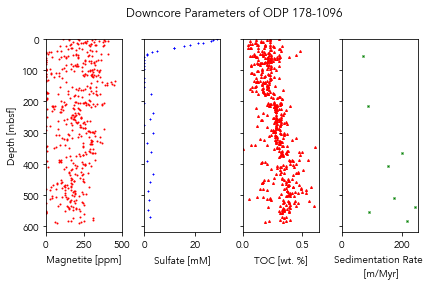

In [10]:
# plot downcore figures (excluding magnetite outliers)
colors = ["r", "b", "r", "g"]
markers = [".", "+", "^", "x"]
dc_fig, dc_axs = data_fns.plot_dc(["Magnetite [ppm]", "Sulfate [mM]", "TOC [wt. %]", "Sedimentation Rate [m/Myr]"], comb_df, colors, markers)

dc_axs[0].set_xlim(0, 500)
dc_axs[3].set_xlabel("Sedimentation Rate \n [m/Myr]")
dc_fig.suptitle("Downcore Parameters of ODP 178-1096", x=0.55)
dc_fig.tight_layout()
dc_fig.savefig("outputs/brachfeld2001/1096_dc_zoom-aug23.pdf")

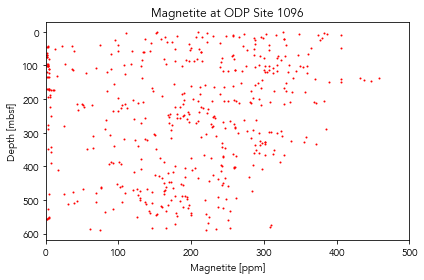

In [18]:
# zoomed-in view of downcore magnetite (interesting trends)
plt.figure()
plt.plot(comb_df["Magnetite [ppm]"], comb_df["Depth [mbsf]"], "r.", markersize=2)
plt.xlabel("Magnetite [ppm]")
plt.ylabel("Depth [mbsf]")
plt.title("Magnetite at ODP Site 1096")
plt.xlim(-0.1, 500)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("outputs/brachfeld2001/mag-zoom.pdf")

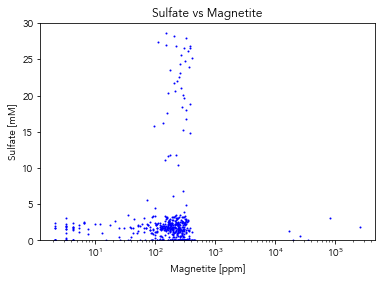

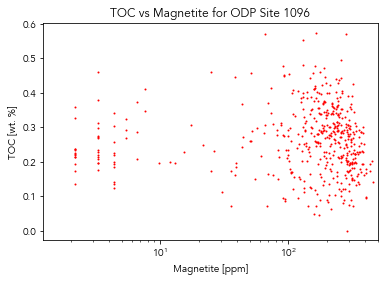

In [9]:
# now we can do the comparison plots
comp_figs, comp_axs = data_fns.plot_comp(["Sulfate [mM]", "TOC [wt. %]"], interpolated, ["b", "r"], [".", "."])

comp_axs[0].set(xlabel="Magnetite [ppm]", ylabel="Sulfate [mM]", title="Sulfate vs Magnetite", xscale="log")
comp_axs[1].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite for ODP Site 1096", xscale="log")
comp_axs[1].set_xlim(xmax=500)
comp_axs[0].set_ylim(ymin=0)
# saving figures
comp_figs[0].savefig("outputs/brachfeld2001/comp_sulf.pdf")
comp_figs[1].savefig("outputs/brachfeld2001/comp_TOC.pdf")

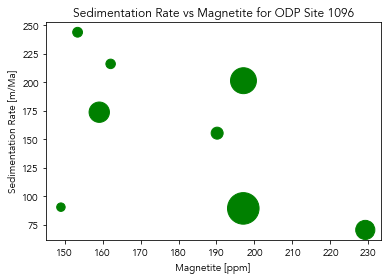

In [18]:
# remove magnetite outliers (ash beds)
filtered = interpolated[interpolated["Magnetite [ppm]"] < 5000]
sed_fig, sed_ax, sed_sc = data_fns.sed_avg_plot(filtered, 6)
sed_ax.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Myr]", title = "Sedimentation Rate vs Magnetite for ODP Site 1096")
sed_fig.savefig("outputs/brachfeld2001/brachfeld2001_sed-comp.pdf")

In [15]:
# compile results and add to compilation excel doc
data_fns.write_output(interpolated, "ODP 178-1096", "data/comp_inter.xlsx")
data_fns.write_output(comb_df, "ODP 178-1096", "data/comp_raw.xlsx")